#### Quantifying Wetland Drought Indices Using Short‑ and Long‑Term Observations
##### Overview
Wetlands are sensitive to changes in water availability. Drought index classification helps identify and track periods of water stress by using indicators based on precipitation, streamflow, and atmospheric demand. This information is critical for monitoring wetland conditions and guiding management decisions.

This tutorial is designed as a step by step process on how to derive commonly used drought metrics for wetlands, first from a high‑frequency flux tower record (ELM site) and then from long‑term hydroclimatological datasets. It demonstrates how to assess drought in a wetland ecosystem using three indicators:
**SPI** (precipitation-based), **SSI** (streamflow-based), and **EDDI** (atmospheric demand-based). We process and compare these indices to detect and map drought events at a monthly scale.

##### Study Site
The site is a coastal freshwater wetland located in Everglades National Park **(Lat: 25.5519, Lon: -80.7826, Elevation: 0.77 m)**. It is part of the **AmeriFlux** and **FCE-LTER** networks and supports long-term CO₂ flux monitoring in a permanently vegetated wetland system.

In [1]:
import folium

flux_tower_coords = (25.5519, -80.7826)
streamflow_coords = (25.76203, -80.7272)

wetland_map = folium.Map(location=flux_tower_coords, zoom_start=10)

folium.Marker(
    location=flux_tower_coords,
    icon=folium.Icon(color="green", icon="leaf"),
    tooltip="Everglades Flux Tower",
).add_to(wetland_map)

folium.Marker(
    location=streamflow_coords,
    icon=folium.Icon(color="blue", icon="tint"),
    tooltip="USGS Tamiami S-12-D",
).add_to(wetland_map)

display(wetland_map)

##### Prerequisites & Environment Check
Before diving in, run the **code cell below** to confirm you have the required Python libraries (`pandas`, `numpy`, `xarray`, `lmoments3`, `scipy`, `matplotlib`, `spei`) installed.  
If any import fails, install the package with `pip install …` or `conda install …` and re‑run!")
```


In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import spei as si
import scipy.stats as scs
import matplotlib.pyplot as plt
import pyet
import lmoments3

##### Part A – Short‑Term, High‑Resolution ELM Dataset  
The Eastern Longleaf Marsh (ELM) flux tower provides sub‑hourly water and energy balance variables spanning **2008‑2024**. We use it to demonstrate drought metrics over a limited yet data‑rich period.

> **Why start here?**  
> Flux towers capture *continuous, site‑specific* dynamics that highlight how wetlands respond to short hydro‑climatic swings. By extracting indices at this temporal granularity we can evaluate whether large‑scale drought products capture local stress.

Using the ELM Flux tower site half hourly dataset, we shall compute Potential ET, and then use the **SPI** and **SPEI** functions from the [SPEI](https://doi.org/10.5281/zenodo.10816741) python package developed by Vonk, M. A. (2024). The potential ET was computed using the method **pyet** package.

**Computing Potential Evapotranspiration**

**Preparing data for computing PET**

**Daily summaries**
- extract the **T-max, T-min, and T-mean** ($^0$C) and daily mean **wind speed** and **RH**.
- Convert mean net radiation from $W/m^2$ to $MJ/m^2 /day$ by multiplying by 86 400 seconds and dividing bt 1000 000

**Run the FAO-56 Penman-Monteith Equation**
- To compute PET, we now feed the variables computed into the package (`pyet.pm_fao56`) including daily met data, and elavation.

In [13]:
daily = pd.read_csv("us_elm_daily_data.csv", parse_dates=["TIMESTAMP_START"])
daily.set_index("TIMESTAMP_START", inplace=True) # Set the timestamp as the index

In [14]:
elevation = 0.77  # metres above sea level from the website=
daily["pet_pm"] = pyet.pm_fao56(
    tmean=daily["tmean"],
    wind=daily["wind"],
    rn=daily["rn"],
    tmax=daily["tmax"],
    tmin=daily["tmin"],
    rh=daily["rh"],
    elevation=elevation,
)

#### Computing the Drough Indices
##### 1. SPI (Standardized Precipitation Index) and SPEI (Standardized Precipitation Evapotranspiration Index)
The Standardized Precipitation Index (SPI), introduced by McKee et al. (1993), is a widely adopted index for quantifying meteorological drought based solely on precipitation. It transforms raw precipitation data using a probability distribution—typically the gamma distribution—and standardizes the result to a normal distribution with a mean of 0 and a standard deviation of 1. SPI values can be computed at various timescales (e.g., 1, 3, 6, 12, 24, 48 months), allowing assessments of short-term to long-term drought impacts. The index is particularly effective in identifying precipitation deficits or surpluses relative to the climatological norm and can be compared across different climate regions.

**The SPI is calculated using**:

$$
\text{SPI} = \frac{P - \mu}{\sigma}
$$

Where:  
- $P$ = observed precipitation  
- $\mu$ = mean precipitation  
- $\sigma$ = standard deviation of precipitation

**SPI Value Interpretation Table**

| SPI Value | Interpretation       | Cumulative Probability |
|-----------|----------------------|------------------------|
| <-2.0      | Extremely dry        | 0.0228                 |
| -1.0      | Moderately dry       | 0.1587                 |
| 0.0       | Near normal          | 0.5000                 |
| +1.0      | Moderately wet       | 0.8413                 |
| >+2.0      | Extremely wet        | 0.9772                 |

Once we obtain $D = P- PET$, computing SPEI follows similar procedure as SPI. However, Unlike SPI, SPEI considers not only precipitation but also evapotranspiration (PET) data on its calculation, allowing for a more complete approach to explore the effects of climate change on drought conditions.EI} > 1\) = wetter than normal.

In [16]:
# Compute the rolling precipitation sum over 30 days
series = daily["prec"].rolling(window=30, min_periods=30).sum().dropna()
series1 = (
    (daily["prec"] - daily["pet_pm"]).rolling(window=30, min_periods=30).sum().dropna()
)
# Compute SPI using a Gamma distribution
daily["SPI"] = si.spi(series, dist=scs.gamma, fit_freq="ME")
daily["SPEI"] = si.spei(series1, dist=scs.gamma, fit_freq="ME")

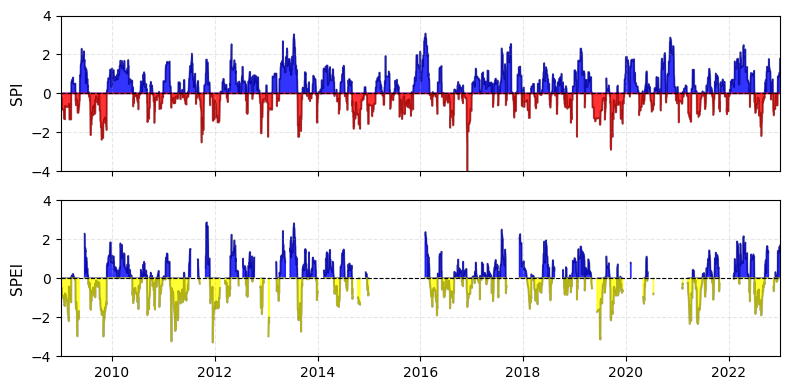

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Create figure and subplots
f, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)


def plot_standardized_index(ax, series, pos_color, neg_color, title):
    """
    Plots standardized index with positive and negative colors.

    Parameters:
    - ax: Matplotlib axis
    - series: Pandas Series (standardized index)
    - pos_color: Color for positive values
    - neg_color: Color for negative values
    - title: Title of the subplot
    """
    ax.axhline(0, linestyle="--", linewidth=0.8, color="k")  # Zero line

    # Separate positive and negative values
    pos_values = series.clip(lower=0)
    neg_values = series.clip(upper=0)

    # Fill between for shading effect
    ax.fill_between(series.index, pos_values, 0, color=pos_color, alpha=0.8)
    ax.fill_between(series.index, neg_values, 0, color=neg_color, alpha=0.8)

    # Plot the main line
    ax.plot(series.index, series, color="black", alpha=0.3, linewidth=1.5)

    # Labels and Limits
    ax.set_ylim(-4, 4)
    ax.set_ylabel(title, fontsize=11)
    ax.grid(linestyle="--", alpha=0.3)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))


# Plot SPI with blue (positive) and red (negative)
plot_standardized_index(
    ax[0], daily["SPI"], pos_color="blue", neg_color="red", title="SPI"
)

# Plot SPEI with yellow (positive) and blue (negative)
plot_standardized_index(
    ax[1], daily["SPEI"], pos_color="blue", neg_color="yellow", title="SPEI"
)
ax[0].set_xlim(pd.to_datetime(["2009", "2023"]))

plt.tight_layout()
plt.show()

#### Part 2: Using NOAA Precipitation, MODIS NDVI data and USGS Streamflow data to quantify Drought

In [18]:
noaa = pd.read_csv(
    "GHCND_USC00087760_PRCP_1950_2025.csv", parse_dates=["date"], index_col="date"
)
missing_percentage = noaa.isnull().mean() * 100


def longest_missing_streak(series):
    """Find the longest consecutive NaN streak in a time series."""
    is_missing = series.isnull()
    longest_streak = (
        is_missing.astype(int).groupby((~is_missing).astype(int).cumsum()).sum()
    ).max()
    return longest_streak


longest_gap = longest_missing_streak(noaa["noaa_precip"])
print(
    f"Overall Precipitation missing data percentage: {missing_percentage.values[0]:.2f}%"
)
print(f"Longest Precipitation consecutive missing period: {longest_gap} days")

Overall Precipitation missing data percentage: 0.00%
Longest Precipitation consecutive missing period: 0 days


In [19]:
# Compute the rolling precipitation sum over 30 days
series = noaa["noaa_precip"].rolling(window=30, min_periods=30).sum().dropna()
# Compute SPI using a Gamma distribution
noaa["SPI"] = si.spi(series, dist=scs.gamma, fit_freq="ME")

Since the other indices have been described already, here we shall describe the standardized streamflow index SSI, but also we shall use the same package as it contains an inbuilt function fo rthe index.
##### Standardized Streamflow Index (SSI)

The Standardized Streamflow Index (SSI) quantifies hydrological drought by standardizing monthly streamflow data using probability distributions. It measures deviations in streamflow from its long-term climatology, allowing for direct comparison across different river basins and time periods. Full method described by [López-Moreno et al. (2011)](https://ascelibrary.org/doi/10.1061/%28ASCE%29HE.1943-5584.0000433)

**Why SSI**

Unlike raw discharge values, SSI transforms streamflow into a standardized Z-score, making it possible to detect drought severity independent of the river's absolute discharge. It is computed independently for each month, preserving seasonality.

| **SSI Value Range** | **Interpretation**           |
|---------------------|------------------------------|
| SSI < -2.0          | Extreme Drought              |
| -2.0 < SSI < -1.5   | Severe Drought               |
| -1.5 < SSI < 0      | Moderate to Mild Drought     |
| 0                   | Normal Conditions            |
| 0 < SSI < 1.5       | Moderate to Mild Wet         |
| 1.5 < SSI < 2.0     | Severe Wet Conditions        |
| SSI > 2.0           | Extreme Wet Conditions       |

- **Negative SSI** values indicate **drought**.
- **Positive SSI** values indicate **wet conditions**.

**Procedure**

**1. Data Preparation**
- Load the daily streamflow data
- Estimate the missing data percentage

In [20]:
sflow = pd.read_csv(
    "USGS_2289041_Discharge.csv", parse_dates=["date"], index_col="date"
)
missing_percentage = sflow.isnull().mean() * 100
longest_gap = longest_missing_streak(sflow["discharge_cfs"])

print(
    f"Overall Streamflow missing data percentage: {missing_percentage.values[0]:.2f}%"
)
print(f"Longest Streamflow consecutive missing period: {longest_gap} days")

Overall Streamflow missing data percentage: 0.08%
Longest Streamflow consecutive missing period: 7 days


**2. Probability Distribution Fitting**

For each month, **L-moment ratios** ($\tau_3, \tau_4$) were computed:

$$
\tau_3 = \frac{\lambda_3}{\lambda_2}, \quad \tau_4 = \frac{\lambda_4}{\lambda_2}
$$

where $\lambda_2, \lambda_3, \lambda_4$ are the second, third, and fourth L-moments.

In [21]:
import lmoments3 as lm
# 30-day rolling mean, center=True aligns the result with the center of the window
sflow = sflow.rolling(window='30D', min_periods=10, center=True).mean()
# Function stays the same
def compute_l_moments(data):
    lmoments = lm.lmom_ratios(data, nmom=4)
    λ1, λ2, τ3, τ4 = lmoments[0], lmoments[1], lmoments[2], lmoments[3]
    return τ3, τ4

# Compute L-moments from the 30-day rolled data
l_moment_ratios = {}
for month in range(1, 13):
    month_data = sflow[sflow.index.month == month]['discharge_cfs'].dropna()
    if len(month_data) > 10:
        l_moment_ratios[month] = compute_l_moments(month_data)

# Convert to DataFrame
l_moment_df = pd.DataFrame(l_moment_ratios, index=['L-skewness (τ3)', 'L-kurtosis (τ4)']).T
print(l_moment_df)

    L-skewness (τ3)  L-kurtosis (τ4)
1          0.502778         0.196481
2          0.620693         0.309505
3          0.651244         0.333571
4          0.639351         0.309330
5          0.603286         0.266255
6          0.433723         0.102907
7          0.226174         0.034860
8          0.116953         0.071229
9          0.052741         0.107042
10         0.121862         0.143290
11         0.166549         0.055104
12         0.322578         0.083240


**3. Testing Streamflow Distribution for each month**

The following six probability distributions were tested:

- **Generalized Pareto (GPA)**
- **Log-logistic (GLO)**
- **Lognormal (GNO)**
- **Pearson Type III (PE3)**
- **General Extreme Value (GEV)**
- **Weibull (WEI)**

In [22]:
import lmoments3.distr as lm_distr
distributions = ["gpa", "glo", "gno", "pe3", "gev", "wei"]

# Function to fit distributions using L-moments
def fit_distributions(data):
    """
    Fits multiple probability distributions using L-moment estimation.
    Returns fitted parameters for each distribution.
    """
    fitted_params = {}
    for dist_name in distributions:
        try:
            params = getattr(lm_distr, dist_name).lmom_fit(data)
            if params:
                fitted_params[dist_name] = params
            else:
                print(f"{dist_name} fitting failed for min={np.min(data)}, max={np.max(data)}")
        except Exception as e:
            print(f"Error fitting {dist_name}: {e}")
            fitted_params[dist_name] = None 
    return fitted_params

# Fit distributions by month using the 30-day rolling mean
fitted_distributions = {}
for month in range(1, 13):
    month_data = sflow[sflow.index.month == month]['discharge_cfs'].dropna()
    if len(month_data) > 10:
        fitted_distributions[month] = fit_distributions(month_data)

# Convert to DataFrame
df_fitted = pd.DataFrame(fitted_distributions)
df_fitted.head()

,1,2,3,4,5,6,7,8,9,10,11,12
gpa,"{'c': 0.33826278180996183, 'loc': -36.90891816...","{'c': 0.5319205778927053, 'loc': -22.447361877...","{'c': 0.5775842620199162, 'loc': -17.366496918...","{'c': 0.560010021111151, 'loc': -11.4070401572...","{'c': 0.505123270373206, 'loc': -8.63505585941...","{'c': 0.2100601119189759, 'loc': -27.067376365...","{'c': -0.2621809181484917, 'loc': -59.66548066...","{'c': -0.5811700915004049, 'loc': -35.97629089...","{'c': -0.799604238067778, 'loc': -9.8550124314...","{'c': -0.565501329431616, 'loc': 99.0080412985...","{'c': -0.4289166050773965, 'loc': -39.20828851...","{'c': -0.024395909220816706, 'loc': -69.796142..."
glo,"{'k': -0.5027779499284947, 'loc': 98.218280544...","{'k': -0.6206933878103166, 'loc': 47.952503803...","{'k': -0.6512442258715571, 'loc': 33.495922415...","{'k': -0.6393509951305482, 'loc': 21.582537402...","{'k': -0.6032856262996031, 'loc': 17.332979992...","{'k': -0.433722646530309, 'loc': 68.6866088319...","{'k': -0.22617356313587614, 'loc': 228.4983931...","{'k': -0.11695336937322563, 'loc': 338.8737248...","{'k': -0.05274121971032689, 'loc': 476.6777835...","{'k': -0.12186187310653686, 'loc': 581.4319198...","{'k': -0.16654922259613056, 'loc': 482.5559909...","{'k': -0.322578167694497, 'loc': 246.058771152..."
gno,"{'k': -1.0995683931722053, 'loc': 87.226628762...","{'k': -1.4167104778168225, 'loc': 38.584430876...","{'k': -1.507390082948974, 'loc': 25.8444445313...","{'k': -1.4715691410625216, 'loc': 16.850223693...","{'k': -1.3668767656172132, 'loc': 14.113200398...","{'k': -0.9310780819836156, 'loc': 62.958080313...","{'k': -0.4685663807775771, 'loc': 222.77550588...","{'k': -0.24013042540402582, 'loc': 335.7850380...","{'k': -0.10801295748029686, 'loc': 475.0814560...","{'k': -0.2502777270902151, 'loc': 577.24983560...","{'k': -0.3431020607485092, 'loc': 475.79946705...","{'k': -0.6771596691947245, 'loc': 235.08367965..."
pe3,"{'skew': 3.099382498409601, 'loc': 204.0335268...","{'skew': 4.067923073417427, 'loc': 143.0455057...","{'skew': 4.371966620241041, 'loc': 113.1599070...","{'skew': 4.250112626287509, 'loc': 70.33275703...","{'skew': 3.9067437086299277, 'loc': 49.6310129...","{'skew': 2.6259727143415974, 'loc': 123.295116...","{'skew': 1.3646791407443861, 'loc': 283.533417...","{'skew': 0.7137617202201457, 'loc': 368.842826...","{'skew': 0.3234022116933507, 'loc': 492.214886...","{'skew': 0.7433703157262417, 'loc': 621.997108...","{'skew': 1.0112567996323192, 'loc': 547.873625...","{'skew': 1.9354702974165583, 'loc': 350.770466..."
gev,"{'c': -0.46089012181786587, 'loc': 52.65006411...","{'c': -0.6019912742641647, 'loc': 22.988995040...","{'c': -0.6370251147900315, 'loc': 15.278882704...","{'c': -0.6234572422616754, 'loc': 9.8111593896...","{'c': -0.5817598465766031, 'loc': 8.1821355193...","{'c': -0.37350819449205064, 'loc': 37.61559833...","{'c': -0.08566346286794842, 'loc': 149.0622146...","{'c': 0.08418174152747639, 'loc': 247.29872786...","{'c': 0.19126069538366275, 'loc': 367.52893675...","{'c': 0.07622965159097832, 'loc': 462.86160947...","{'c': 0.005259708762950376, 'loc': 347.4329020...","{'c': -0.2244772096646682, 'loc': 151.23098937..."


**4. Selecting the best Distribution function for each month**

The best distribution for each month was selected using the **Minimum Orthogonal Distance (MD) method**:

$$
D = \sqrt{(\tau_3 - \tau_3^{(theo)})^2 + (\tau_4 - \tau_4^{(theo)})^2}
$$

where $\tau_3^{(theo)}, \tau_4^{(theo)}$ are **theoretical L-moment ratios** for each candidate distribution.

In [23]:
import numpy as np

# Function to compute the best-fitting distribution based on minimum orthogonal distance in L-moment space
def minimum_orthogonal_distance(l_skew, l_kurt, fitted_params):
    best_dist, min_distance = None, np.inf

    for dist_name, params in fitted_params.items():
        if params is None:
            continue
        try:
            lmom = getattr(lm_distr, dist_name).lmom(nmom=4, **params)
            τ3_theoretical = lmom[2] / lmom[1]
            τ4_theoretical = lmom[3] / lmom[1]
            distance = np.hypot(l_skew - τ3_theoretical, l_kurt - τ4_theoretical)  # cleaner than sqrt(x² + y²)

            if distance < min_distance:
                best_dist, min_distance = dist_name, distance
        except Exception as e:
            print(f"Error in {dist_name}: {e}")
            continue

    return best_dist

# Determine best distribution per month
best_distributions = {
    month: minimum_orthogonal_distance(τ3, τ4, fitted_distributions[month])
    for month, (τ3, τ4) in l_moment_ratios.items()
}

# Convert to DataFrame
best_dist_df = pd.DataFrame.from_dict(best_distributions, orient='index', columns=['Best Distribution'])
print(best_dist_df)

   Best Distribution
1                pe3
2                pe3
3                pe3
4                pe3
5                pe3
6                pe3
7                gpa
8                wei
9                wei
10               gno
11               gpa
12               gpa


**5. Standardized Streamflow Index (SSI)**

Once the best distribution was selected for each month:

- **Cumulative probability ($P$)** was computed for each observed streamflow ($Q$):

$$
P = F(Q)
$$

where $F(Q)$ is the **cumulative distribution function (CDF)** of the best-fit distribution.

- **Transformation to a standard normal variable (SSI):**

$$
SSI = \Phi^{-1}(P)
$$

where $\Phi^{-1}$ is the **inverse standard normal function**.

In [24]:
import scipy.stats as stats

def compute_ssi(sflow, best_distributions, fitted_distributions):
    """
    Computes the Standardized Streamflow Index (SSI) for daily 30-day rolled streamflow
    using best L-moment-based distribution by month.
    """
    ssi_values = []
    for index, row in sflow.iterrows():
        month = index.month
        best_dist = best_distributions.get(month)
        params = fitted_distributions.get(month, {}).get(best_dist)

        try:
            value = float(row['discharge_cfs'])
            if not np.isfinite(value):
                raise ValueError("Invalid value")

            cdf = getattr(lm_distr, best_dist).cdf(value, **params)
            ssi = stats.norm.ppf(cdf)
            ssi_values.append(ssi)
        except Exception as e:
            print(f"Error computing SSI at {index.date()} (Month {month}): {e}")
            ssi_values.append(None)

    return pd.Series(ssi_values, index=sflow.index)

# Fix version with safe renaming
df_valid = sflow[["discharge_cfs"]].dropna().copy()

# Compute SSI and assign back
sflow["SSFI"] = compute_ssi(df_valid, best_distributions, fitted_distributions)

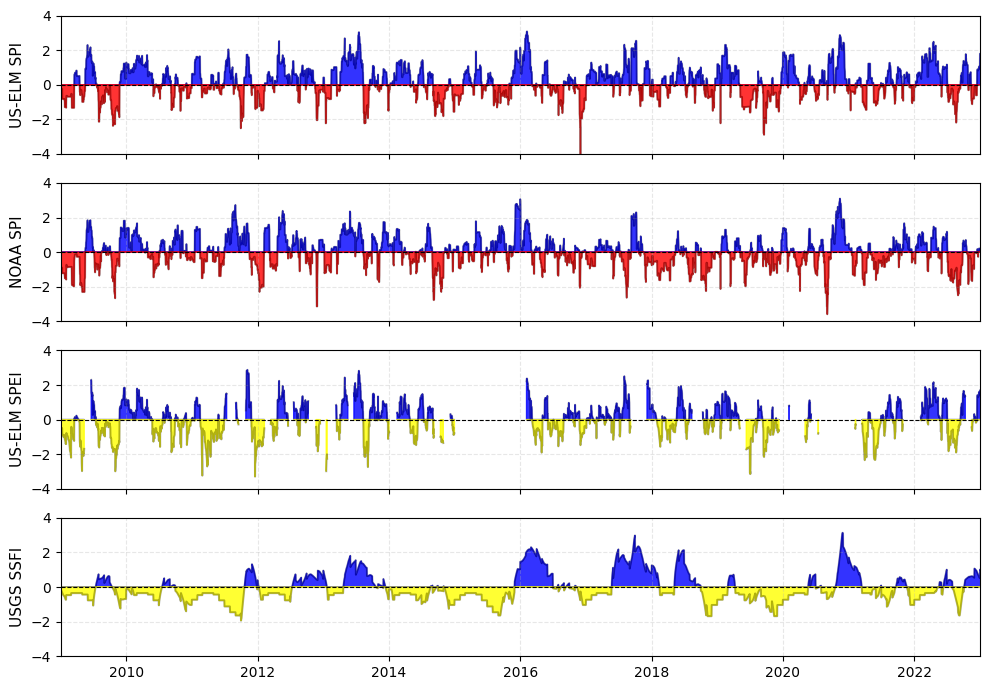

In [25]:
f, ax = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
# Plot SPI with blue (positive) and red (negative)
plot_standardized_index(
    ax[0], daily["SPI"], pos_color="blue", neg_color="red", title="US-ELM SPI"
)
plot_standardized_index(
    ax[1], noaa["SPI"], pos_color="blue", neg_color="red", title="NOAA SPI"
)
plot_standardized_index(
    ax[2], daily["SPEI"], pos_color="blue", neg_color="yellow", title="US-ELM SPEI"
)
plot_standardized_index(
    ax[3], sflow["SSFI"], pos_color="blue", neg_color="yellow", title="USGS SSFI"
)
ax[0].set_xlim(pd.to_datetime(["2009", "2023"]))

plt.tight_layout()
plt.show()

##### Computing Standardized NDVI
We extract the NDVI values for the location using the 500m resolution 16-day MODIS dataset. We handle NDVI seasonallity by applying additive seasonal decomposition (period=23, i.e. ~1 year of 16‑day steps). The deseasonalized signal = trend + residual, giving a baseline NDVI that’s free of predictable phenology.

We then Compute a centred 32‑day rolling mean (two composite periods) to dampen noise and cloud artefacts.
$$
SNDVI = \frac{NDVI_{32}-\mu}{\sigma}
$$

In [39]:
import numpy as np
import pandas as pd
import xarray as xr
from statsmodels.tsa.seasonal import seasonal_decompose

ndvi_df = pd.read_csv("modis_ndvi_data_lat_25.5519_lon_-80.7826.csv", parse_dates=["time"])
ndvi_df.set_index("time", inplace=True)

# Seasonal decomposition to extract trend and residual
decomp = seasonal_decompose(ndvi_df["NDVI"], model="additive", period=23)
ndvi_df["deseasonalized_NDVI"] = decomp.trend + decomp.resid

ndvi_df["rolling_32D_NDVI"] = (
    ndvi_df["deseasonalized_NDVI"].rolling(window=2, min_periods=2).mean()
)

# Standardized NDVI based on the rolling 32-day mean
ndvi_df["SNDVI"] = (
    ndvi_df["rolling_32D_NDVI"] - ndvi_df["rolling_32D_NDVI"].mean()
) / ndvi_df["rolling_32D_NDVI"].std()

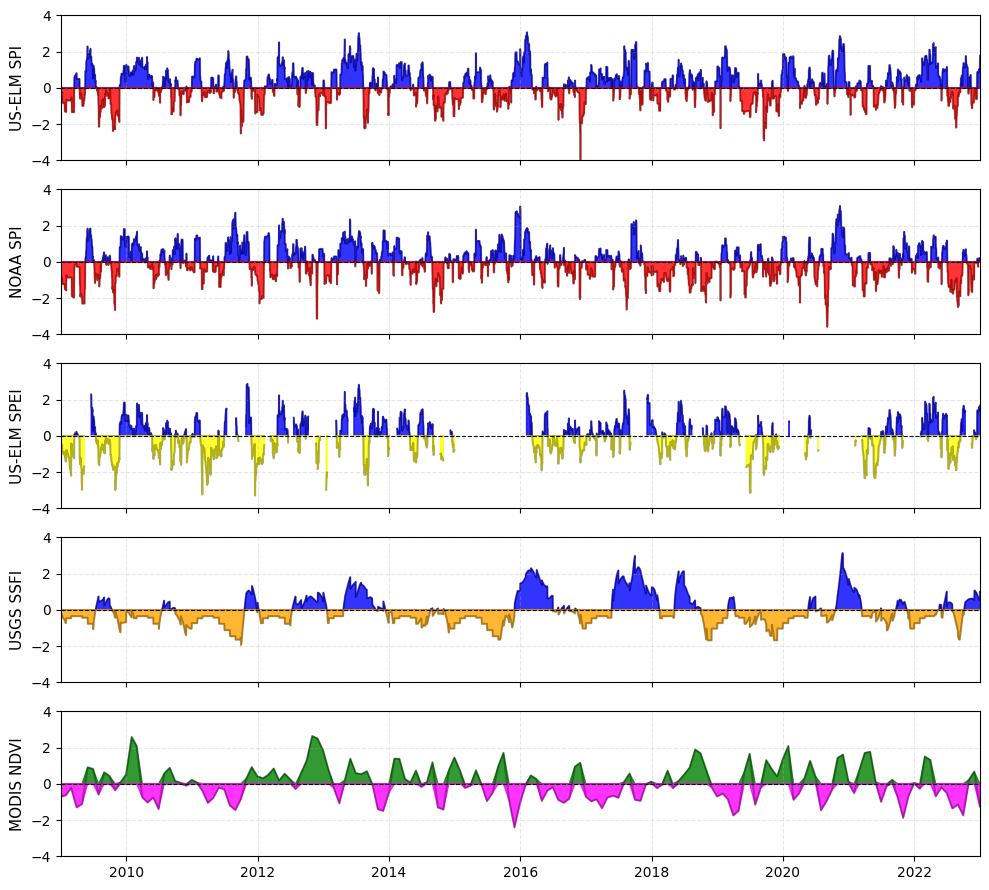

In [40]:
f, ax = plt.subplots(5, 1, figsize=(10, 9), sharex=True)
# Plot SPI with blue (positive) and red (negative)
plot_standardized_index(
    ax[0], daily["SPI"], pos_color="blue", neg_color="red", title="US-ELM SPI"
)
plot_standardized_index(
    ax[1], noaa["SPI"], pos_color="blue", neg_color="red", title="NOAA SPI"
)
plot_standardized_index(
    ax[2], daily["SPEI"], pos_color="blue", neg_color="yellow", title="US-ELM SPEI"
)
plot_standardized_index(
    ax[3], sflow["SSFI"], pos_color="blue", neg_color="orange", title="USGS SSFI"
)
plot_standardized_index(
    ax[4], ndvi_df["SNDVI"], pos_color="green", neg_color="Magenta", title="MODIS NDVI"
)
ax[0].set_xlim(pd.to_datetime(["2009", "2023"]))

plt.tight_layout()
plt.show()

In [41]:
# Combine all indices into a DataFrame
corr_df = pd.DataFrame({
    "US-ELM SPI": daily["SPI"],
    "NOAA SPI": noaa["SPI"],
    "US-ELM SPEI": daily["SPEI"],
    "USGS SSFI": sflow["SSFI"],
    "MODIS NDVI": ndvi_df["SNDVI"]
})

# Drop rows with any missing values
corr_df_clean = corr_df.copy()

# Compute correlation matrix (rounded to 3 decimal places)
correlation_matrix = corr_df_clean.corr().round(3)

print(correlation_matrix)

             US-ELM SPI  NOAA SPI  US-ELM SPEI  USGS SSFI  MODIS NDVI
US-ELM SPI        1.000     0.557        0.872      0.284       0.034
NOAA SPI          0.557     1.000        0.563      0.200       0.014
US-ELM SPEI       0.872     0.563        1.000      0.261       0.003
USGS SSFI         0.284     0.200        0.261      1.000       0.067
MODIS NDVI        0.034     0.014        0.003      0.067       1.000


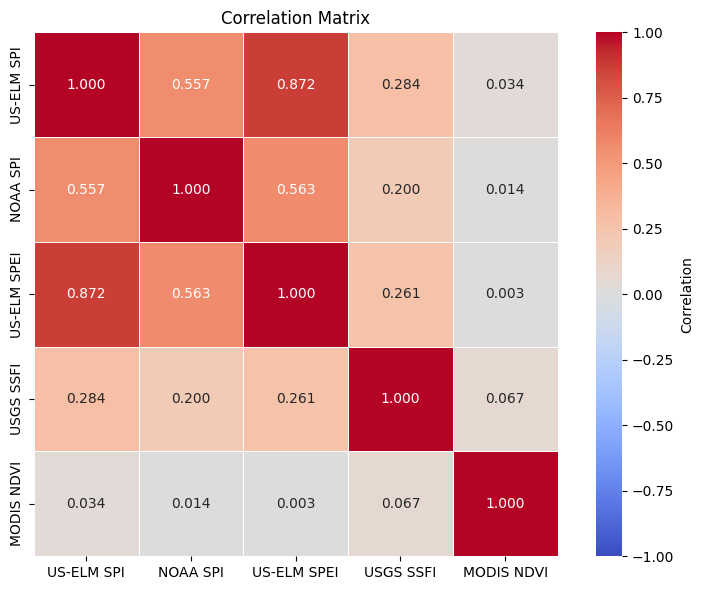

In [42]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

##### **Multi-Index Drought Signal Comparison for the US-ELM Wetland (2009–2022)**

In this tutorial, we demonstrate how to characterize drought conditions using five standardized indices at the US-ELM (Everglades Florida) wetland site over a 14-year period. In the last plot, the top four panels represent standardized anomalies in hydrometeorological variables, while the fifth panel shows vegetation response using satellite derived (MODIS) NDVI Anomaly.

**Conclusion**

**1. US-ELM SPI vs. NOAA SPI (Panels 1–2)**
Both SPI panels reflect 30-day standardized precipitation anomalies, derived from the US-ELM tower gauge and NOAA GHCND data respectively. We see consistent patterns, capturing high-frequency meteorological variability. Notable drought events appear in mid-2011, early 2015, late 2016, and most prominently in mid-to-late 2019. The NOAA SPI tends to show slightly more conservative extremes.

**2. US-ELM SPEI (Panel 3)**
The SPEI incorporates both precipitation and atmospheric water demand (PET), offering a more integrated view of hydroclimatic stress. It highlights extended dry periods more clearly than SPI, especially post-2015. The 2019 drought appears as the most prolonged and intense negative excursion in the series (SPEI < –2.5), reflecting combined low precipitation and high evaporative demand.

**3. USGS SSI (Panel 4)**
The SSI shows hydrological drought from the perspective of 30-day streamflow anomalies within the wetland. It lags behind meteorological indices, confirming delayed catchment response. Positive anomalies dominate in 2012–2014 and 2017–2018, while 2011–2012, 2016, 2019, and 2020 show sustained low-flow conditions.

**4. MODIS NDVI (Panel 5)**
The standardized NDVI (SNDVI) captures vegetation greenness anomalies. Periods of enhanced greenness align with hydrological wet years (2011, 2013–2014, 2018), while below-normal values coincide with drought periods. The most defined vegetation stress signals occur during 2012, 2016, and 2019, in agreement with negative SPI/SPEI and SSI values. The strong dip in 2019 confirms that the hydrological drought translated into observable ecosystem stress.

The multi-index comparison demonstrates both concurrence and temporal lag between meteorological, hydrological, and ecological drought signals. SPI and SPEI capture short-term atmospheric deficits, with SPEI offering more nuanced detection under high PET conditions. SSI reveals that streamflow deficits are more persistent and delayed relative to atmospheric inputs. Vegetation response as captured by NDVI correlates well with SPEI and SSI, suggesting that water availability, rather than just precipitation is the dominant driver of ecosystem stress at this site.